# load snps from vcf files

In [1]:
import allel
from os import path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData


data_dir = '/data/home/sniu/pancreas/microarray'
# fname = 'ALL.TGP_HGDP.GRCh37.bi.sorted.fixref.phased.isec.23andMe.5000-1000-0.01_pairwise.vcf.gz'
fname = "with_simon.vcf.gz"  ## merged with Simon's genotypes
tabix = '/usr/local/bin/tabix'
info = allel.read_vcf(path.join(data_dir, fname),log=sys.stdout)




Bad key "text.kerning_factor" on line 4 in
/data/home/sniu/anaconda3/envs/cs/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/data/home/sniu/anaconda3/envs/cs/lib/python3.6/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


[read_vcf] 22843 rows in 5.73s; chunk in 5.73s (3987 rows/s)
[read_vcf] all done (3985 rows/s)


In [2]:
sample = info['samples'] # sample ID

In [3]:
#to genotype array
gt = allel.GenotypeArray(info['calldata/GT'], dtype = 'i1')
gt = gt.to_n_alt(fill = -1)

# first type of imputing is just using the most common allele in "whole population"

In [4]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=-1, strategy='most_frequent')
gt_impute = imp_mean.fit_transform(gt)

# In this dataset we have 22843 snps, 3433 individuals

In [5]:
gt.shape

(22843, 3434)

In [6]:
gt_impute.shape # this does not work well

(22843, 3434)

# load metadata

In [7]:
# read 
sample_info = pd.read_pickle('sample_info.pickle')

# load custom colors
from custome_color import *

In [8]:
sample_info.columns

Index(['pop', 'super_pop', 'gender', 'batch'], dtype='object')

In [9]:
df2 = pd.DataFrame([['unknown','unknown','M','23andme']], columns=list(sample_info.columns), index = ['simon'])


In [10]:
sample_info = sample_info.append(df2)

In [11]:
# to use scanpy, everything has to go into AnnData, see https://anndata.readthedocs.io/en/stable/anndata.AnnData.html
adata = AnnData(X = gt.T, obs = sample_info.loc[sample])
adata_imp = AnnData(X = gt_impute.T, obs = sample_info.loc[sample])

In [12]:
# every other low dimensional visualization is based on PCA; pca is already slow for 15000 snps
sc.tl.pca(adata)
sc.tl.pca(adata_imp)

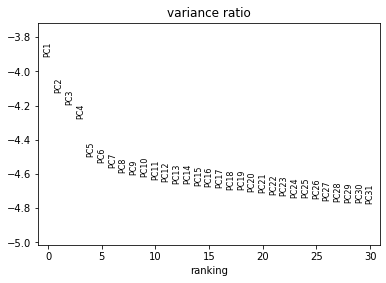

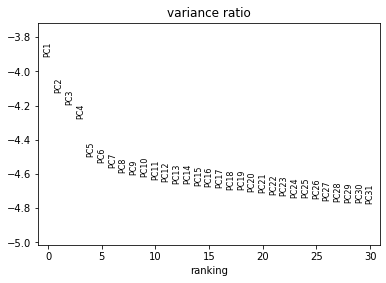

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca_variance_ratio(adata_imp, log=True)

In [14]:
import sklearn

In [15]:
# pca = sklearn.decomposition.PCA(n_components=20, copy=True, whiten=False, 
#                                 svd_solver='auto', tol=0.0, iterated_power='auto', random_state=1994)
# white_pc = pca.fit_transform(adata.X)
# other_pc =white_pc[:, 1:]
# adata.obsm['X_pca'] = white_pc
# pc_uns = {'variance_ratio': pca.explained_variance_ratio_,
#           'variance': pca.explained_variance_}
# adata.uns['pca'] = pc_uns
# adata.varm['PCs'] = pca.components_.T

In [16]:
# use nearest neighbor way to fill -1 entry
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)
sc.pp.neighbors(adata_imp, n_neighbors=10, n_pcs=8)

In [17]:
sc.tl.louvain(adata, resolution=1)
sc.tl.louvain(adata_imp, resolution=1)

... storing 'pop' as categorical
... storing 'super_pop' as categorical
... storing 'gender' as categorical
... storing 'batch' as categorical


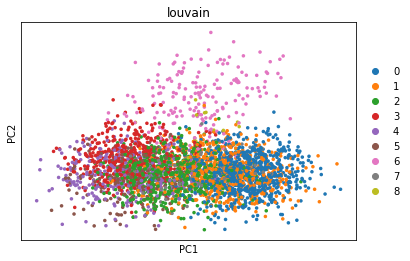

... storing 'pop' as categorical
... storing 'super_pop' as categorical
... storing 'gender' as categorical
... storing 'batch' as categorical


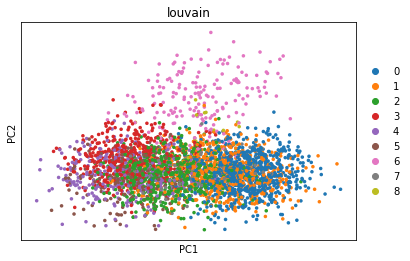

In [18]:
sc.pl.pca(adata, color='louvain', size=50)
sc.pl.pca(adata_imp, color='louvain', size=50)

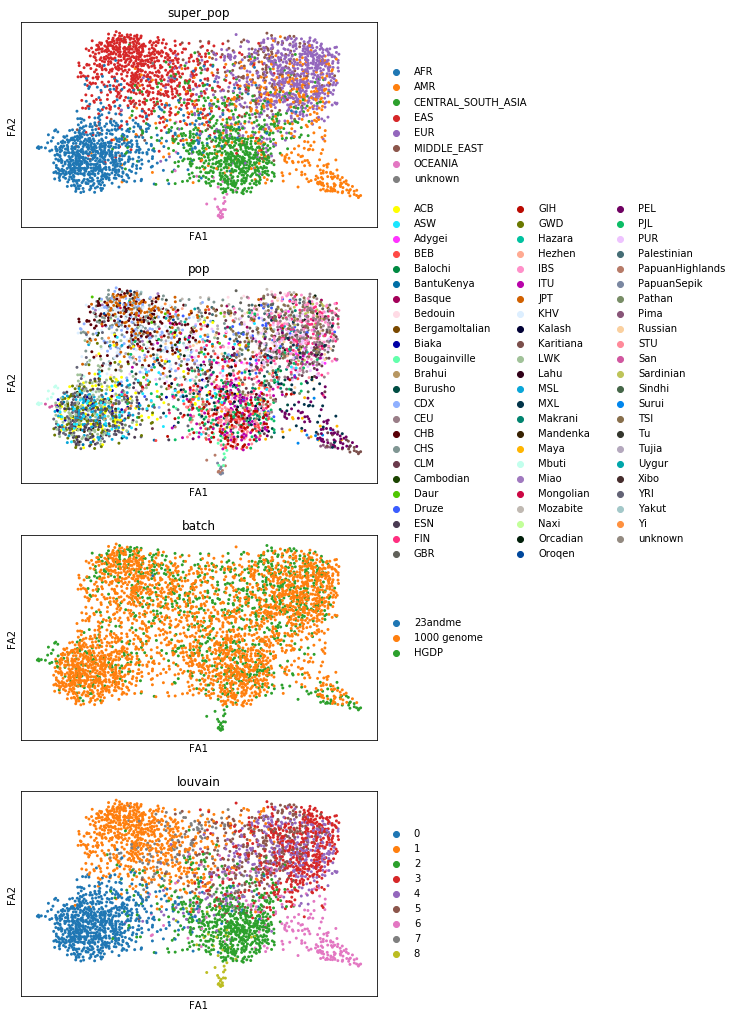

In [25]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color = ['super_pop','pop', 'batch','louvain'], legend_loc = 'right margin', ncols = 1)

In [21]:

# customize color
adata.uns['super_pop_colors'] = adata.obs['super_pop'].cat.categories.map(super_pop_color)
adata.uns['pop_colors'] = adata.obs['pop'].cat.categories.map(pop_to_color)

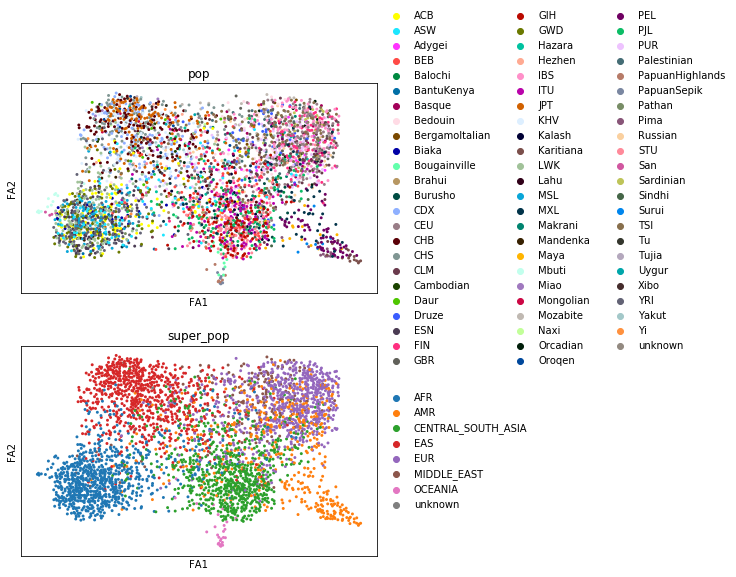

In [22]:
sc.pl.draw_graph(adata, color = ['pop', 'super_pop'], legend_loc = 'right margin', ncols = 1)

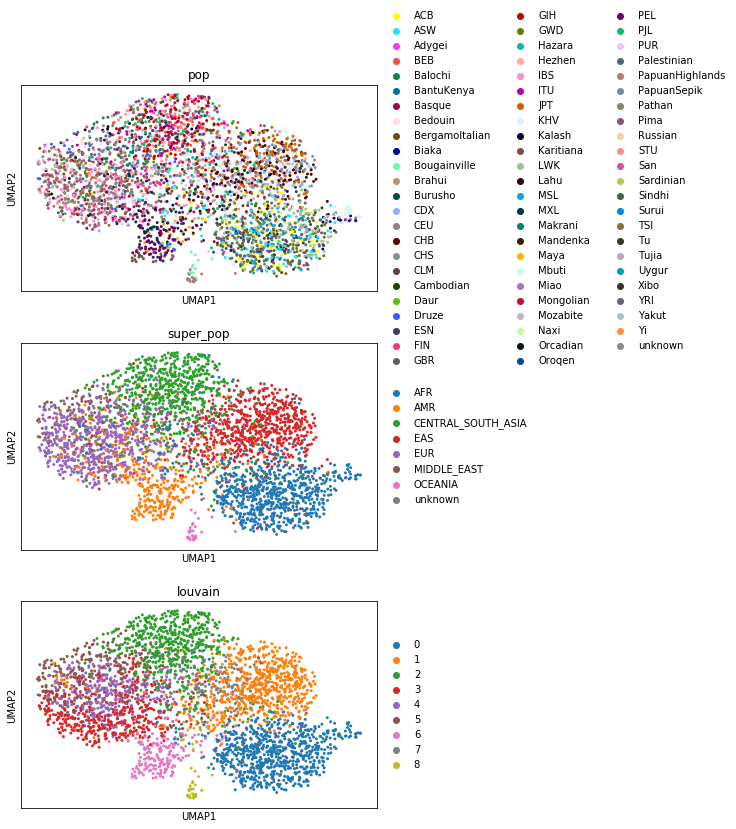

In [26]:
# do umap

sc.tl.umap(adata)
sc.pl.umap(adata, color = ['pop', 'super_pop', 'louvain'], legend_loc = 'right margin', ncols = 1)

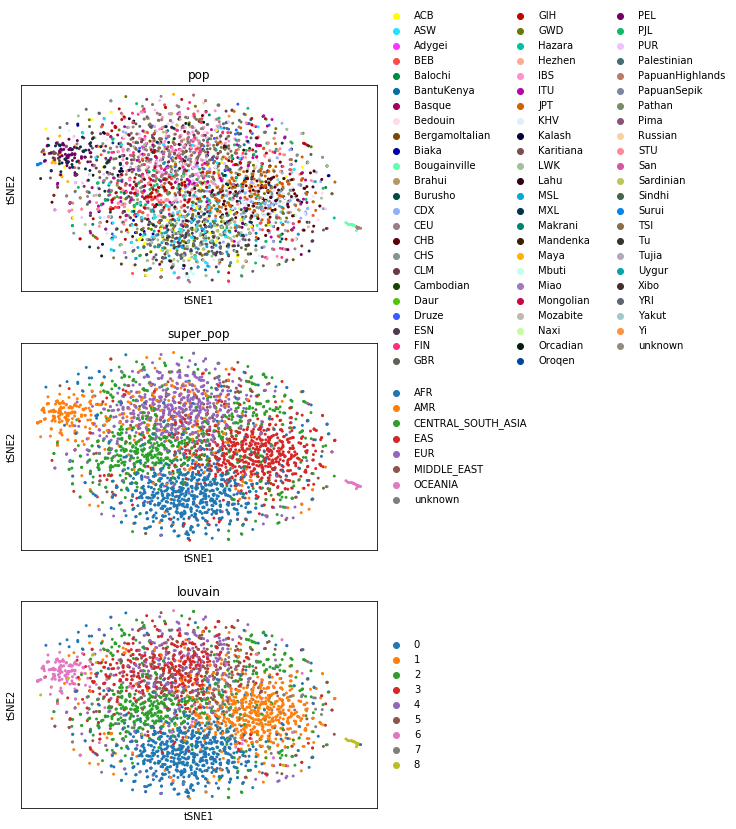

In [27]:
# to tsne
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['pop', 'super_pop', 'louvain'], legend_loc = 'right margin', ncols = 1)

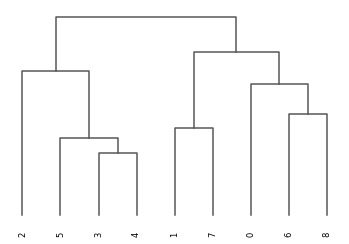

In [31]:
sc.tl.dendrogram(adata, groupby='louvain')
sc.pl.dendrogram(adata, groupby='louvain')
# sc.pl.dotplot(adata, groupby='louvain', dendrogram=True)

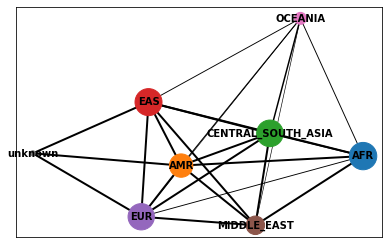

In [32]:
# do PAGA
sc.tl.paga(adata, groups='super_pop')
sc.pl.paga(adata, color=['super_pop'], max_edge_width = 2, node_size_scale= 4)

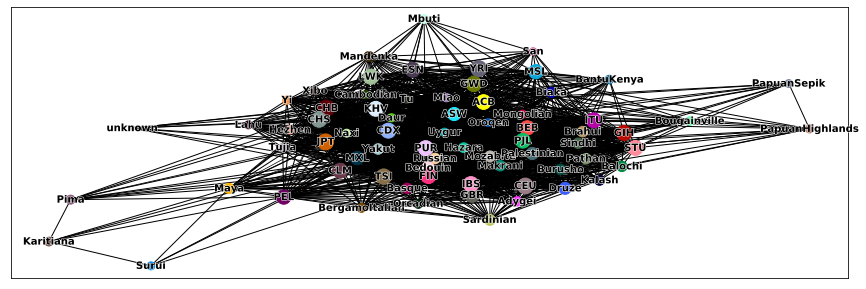

In [33]:
# do PAGA
_, axs = plt.subplots(ncols=1, figsize=(15, 5))
sc.tl.paga(adata, groups='pop')
sc.pl.paga(adata, color=['pop'], max_edge_width = 1, node_size_scale= 1, layout = 'fr', ax = axs, fontoutline = 1)

# save file for later analysis

In [ ]:
adata.uns['super_pop_colors'] = [] # these cannot be written into h5ad
adata.uns['pop_colors'] = []
adata.write(path.join(data_dir, 'par_knn.h5ad'))